In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.preprocessing import OneHotEncoder
from keras.applications.resnet import ResNet50
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv2D, Flatten
from keras.callbacks import TensorBoard
import tensorflow as tf
import time

Using TensorFlow backend.
/home/sagnik106/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sagnik106/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sagnik106/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sagnik106/.local/lib/python3.6/site-packages/tenso

# Data preprocessing

In [2]:
table=pd.read_csv("fer2013.csv").values
x=list()
for i in range(table.shape[0]):
    table[i][1]=np.uint8(np.asarray(table[i][1].split(' ')).reshape((48,48,1)))
    im=table[i][1]
    im=cv2.merge([im,im,im])
    x.append(im)
    print("Current row : %d"%i,end="\r")
print("\nDone!")
table=table[:,:-1]
x=np.float32(np.asarray(x))/255.0
y=np.uint8(table[:,0])
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
y = onehot_encoder.fit_transform(y.reshape(-1,1))
np.save("xval.npy",x)
np.save("yval.npy",y)
np.save("data.npy",table)

Current row : 13309

KeyboardInterrupt: 

In [2]:
x=np.load('xval.npy')
y=np.load('yval.npy')

In [3]:
table=np.load('data.npy', allow_pickle=True)

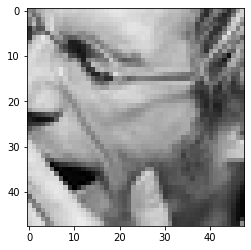

In [4]:
image=x[random.randint(0,x.shape[1]-1)]
plt.imshow(np.asarray(image.reshape(48,48,3)))
plt.show()

In [5]:
resnet=ResNet50(weights='imagenet', include_top=False, input_shape=(x.shape[1],x.shape[2],3))
resnet.summary()

n[0][0]          
__________________________________________________________________________________________________
conv3_block4_out (Activation)   (None, 6, 6, 512)    0           conv3_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_conv (Conv2D)    (None, 3, 3, 256)    131328      conv3_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block1_1_bn (BatchNormali (None, 3, 3, 256)    1024        conv4_block1_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 3, 3, 256)    0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 3, 3, 256)    590080      conv4_block1_1_relu[0][0] 

In [6]:
# model.add(Input(shape=(48,48,1)))
# model.add(Conv2D(filters=3,kernel_size=3,padding='same'))
mx=resnet.output
mx=Flatten()(mx)
mx=Dense(1000,activation='relu')(mx)
mx=Dense(y.shape[1],activation='softmax')(mx)
model=Model(resnet.input,mx)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

onv[0][0]        
__________________________________________________________________________________________________
conv4_block1_1_relu (Activation (None, 3, 3, 256)    0           conv4_block1_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_2_conv (Conv2D)    (None, 3, 3, 256)    590080      conv4_block1_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_bn (BatchNormali (None, 3, 3, 256)    1024        conv4_block1_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_block1_2_relu (Activation (None, 3, 3, 256)    0           conv4_block1_2_bn[0][0]          
__________________________________________________________________________________________________
conv4_block1_0_conv (Conv2D)    (None, 3, 3, 1024)   525312      conv3_block4_out[0][0]    

In [7]:
tensorboard=TensorBoard(log_dir="log/%f"%(time.time()))
tensorboard.set_model(model)

In [8]:
with tf.device('/gpu:0'):
    history=model.fit(x,y,epochs=10,batch_size=128,validation_split=0.1,shuffle=True,verbose=1,callbacks=[tensorboard])


Train on 32298 samples, validate on 3589 samples
Epoch 1/10
15616/32298 [=============>................] - ETA: 9:51 - loss: 1.8920 - accuracy: 0.3999

KeyboardInterrupt: 

In [0]:
model.save("detect.h5")

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy'], loc='upper left')
plt.savefig("Accuracy.png")
plt.show()

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Validation Loss'], loc='upper right')
plt.savefig("Loss.png")
plt.show()